#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [36]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean = inputs[0]
        z_var = inputs[1]
        return z_mean + tf.exp(z_var / 2) * tf.keras.backend.random_normal(tf.shape(z_mean))

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

**Number of layers**: the architecture has 3 levels and I felt it was a sufficient number to allow the model to encode the most relevant information in the latent space.

**Layers sizes**: the transition from one level to another is substantial in terms of size. The layers sizes have been chosen in a way that allow the model to learn only the most important features of the data and to discard the useless ones. 

**Activation functions**: using a non-linear activation function allows to learn better the most important features of the data. The reason why I chose the *hyperbolic tangent* because it copes better with the *vanishing gradient problem*. It is a function similar to the *sigmoid* but it is prone to the vanishing problem. In particular, using a sigmoidal function in a neural network, during the backward propagation, the network calculates the gradients based on the *chain rule*. This process implies that the gradient decreases exponentially. If we want to look deeper the difference between tanh and sigmoid, we have to look the *first derivative*. When the sigmoid function value is either too high or too low, the first derivative becomes very small. This causes vanishing gradients and this implies a poor learning for neural networks. This can occur when the weights of our networks are initialized poorly (with too-large negative and positive values). These too-large values *saturate* the input to the sigmoid and the first derivatives gives small values. However, even if the weights are initialized nicely, the first derivative return values around the maximum ($0.2$). Therefore, a large change in the input of the sigmoid function will cause a small change in the output. Instead, the first derivative of tanh can return a value in the range $(0, 1)$, in this way it is able to preserve the gradient. In this case, the tanh is useful to predicts the values for the pixels of the output images.

The *linear activation function* has been selected as the activation function for dense layers in order not to change the values they receive in input.

In [52]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))

#[TO COMPLETE]
x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_198 (Dense)               (None, 256)          200960      input_45[0][0]                   
__________________________________________________________________________________________________
dense_199 (Dense)               (None, 128)          32896       dense_198[0][0]                  
__________________________________________________________________________________________________
dense_200 (Dense)               (None, 64)           8256        dense_199[0][0]                  
____________________________________________________________________________________________

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

The decoder was built in the reverse of the encoder. The aim of the decoder is to reconstruct the input, starting from the latent space created by the encoder. Thanks to the decoder, we can see if the encoder was able to detect the most important features of the input data and encode them in the latent space.

For the last level, the chosen activation function is the *sigmoid*. If we look at the second code cell of this notebook, we can see that the images have been *normalized*. So, the values the pixels are between 0 and 1. For this reason, the tanh function is not suitable for the last layer. The sigmoid function gives in output value between 0 and 1. So, it allows to predict the pixels of the output image.

In [53]:
latent_inputs = keras.Input(shape=(latent_dim,))
#[TO COMPLETE]
x = tf.keras.layers.Dense(64, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(256, activation='tanh')(x)

decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_203 (Dense)            (None, 64)                192       
_________________________________________________________________
dense_204 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_205 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_206 (Dense)            (None, 784)               201488    
Total params: 243,024
Trainable params: 243,024
Non-trainable params: 0
_________________________________________________________________


##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [54]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(data.shape[1] * tf.keras.losses.binary_crossentropy(data, reconstruction)) #[TO COMPLETE]
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var)), axis=1))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [55]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 2s 4ms/step - loss: 202.6712 - reconstruction_loss: 199.0417 - kl_loss: 3.6295
Epoch 2/30
391/391 [==============================] - 1s 4ms/step - loss: 174.1740 - reconstruction_loss: 169.8119 - kl_loss: 4.3621
Epoch 3/30
391/391 [==============================] - 1s 4ms/step - loss: 163.1308 - reconstruction_loss: 158.3038 - kl_loss: 4.8270
Epoch 4/30
391/391 [==============================] - 1s 4ms/step - loss: 156.8103 - reconstruction_loss: 151.5179 - kl_loss: 5.2924
Epoch 5/30
391/391 [==============================] - 1s 4ms/step - loss: 153.1605 - reconstruction_loss: 147.6166 - kl_loss: 5.5440
Epoch 6/30
391/391 [==============================] - 1s 4ms/step - loss: 150.6332 - reconstruction_loss: 144.9025 - kl_loss: 5.7307
Epoch 7/30
391/391 [==============================] - 1s 3ms/step - loss: 148.9521 - reconstruction_loss: 143.1094 - kl_loss: 5.8427
Epoch 8/30
391/391 [==============================] - 1s 4ms/step - l

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

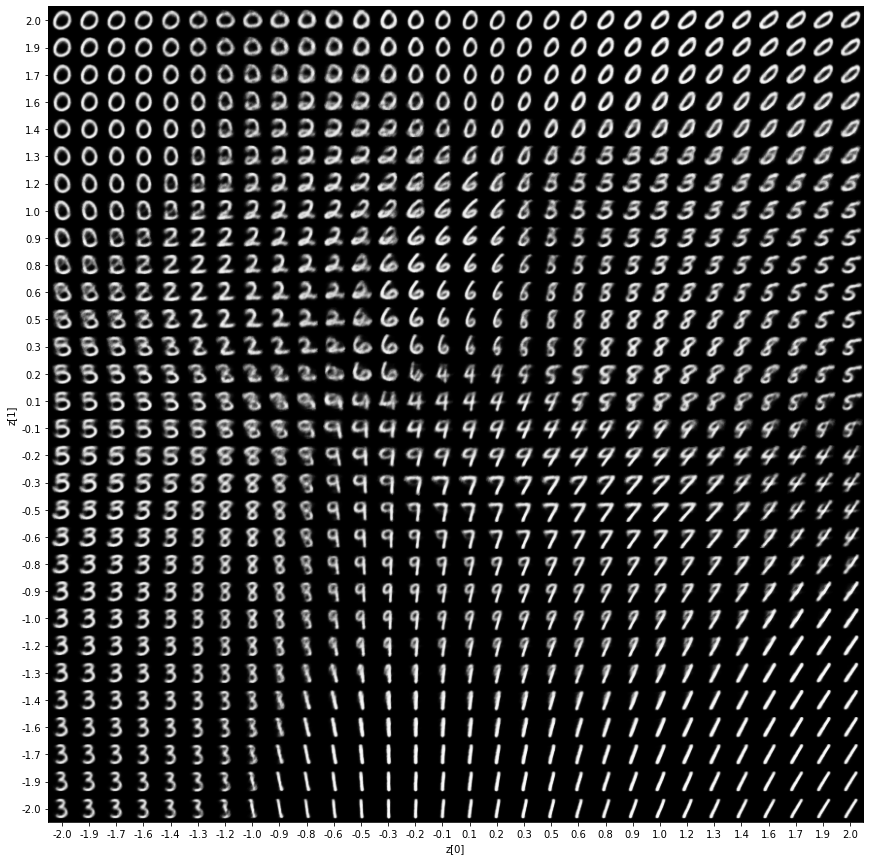

In [56]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#[TO COMPLETE] explore with different "scale"

In [57]:
values = [0.6, 0.9, 2.1, 3.7, 5.4]

for value in values:
  print('Scale value: {}'.format(str(value)))
  plot_latent(encoder, decoder, value, 30)

Output hidden; open in https://colab.research.google.com to view.

I noticed that with small scale values the model is only able to reproduce a few digits. With larger scale values, the model is capable of reproducing more digits. However, we can see that with a higher value, the model fails to be able to reproduce the digits correctly or reproduce a blurry version of them. The reason could be that the value of the scale exceeds the border of the latent space, so the model is not able to reproduce correctly the digits.

Let's finally check how the various digits have been rapresented in the latent space by the VAE.

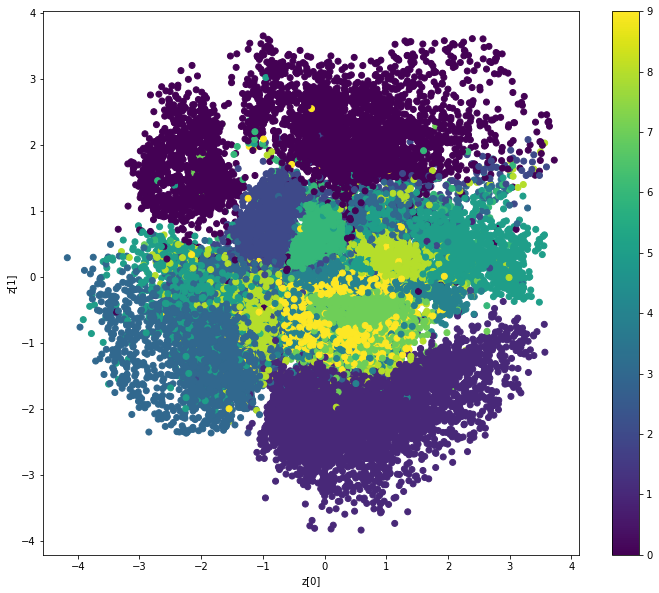

In [58]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

The model is able to reproduce more or less all the figures. We can see that the model is able to distinguish the digits 0, 1 and 2 well. It has some difficulty with 3, 4 and 5. With other digits the model has difficulty separating them clearly, the dots are overlapped among them. This means that the model has to be improved in a way to learn better the most important features of the digits.

**Increasing the number of layers**

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_149 (Dense)               (None, 256)          200960      input_34[0][0]                   
__________________________________________________________________________________________________
dense_150 (Dense)               (None, 128)          32896       dense_149[0][0]                  
__________________________________________________________________________________________________
dense_151 (Dense)               (None, 64)           8256        dense_150[0][0]                  
____________________________________________________________________________________________

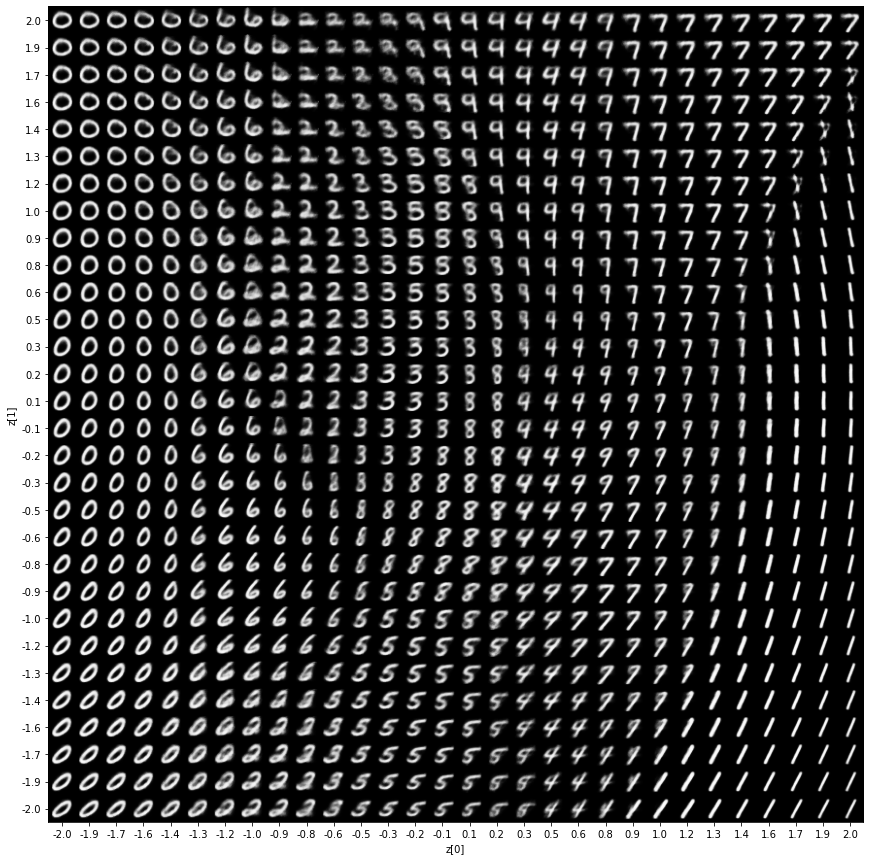

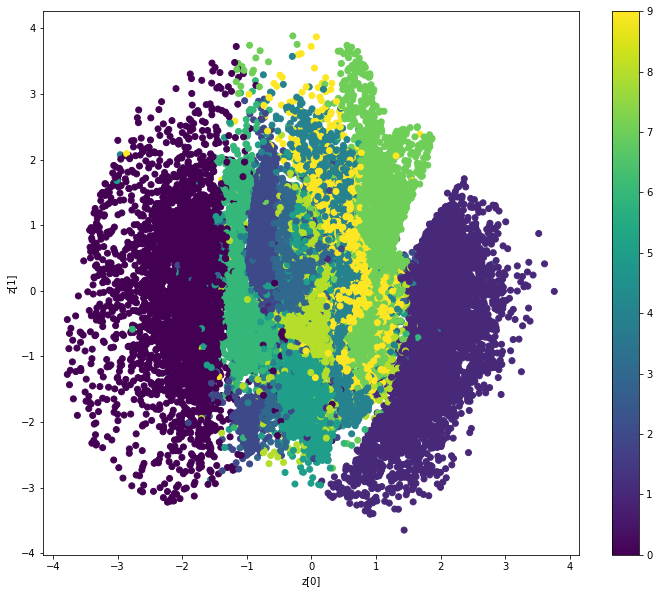

In [44]:
# Model 1
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.Dense(32, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(32, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(256, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

**Decreasing the number of layers**

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_160 (Dense)               (None, 256)          200960      input_36[0][0]                   
__________________________________________________________________________________________________
dense_161 (Dense)               (None, 128)          32896       dense_160[0][0]                  
__________________________________________________________________________________________________
dense_162 (Dense)               (None, 2)            258         dense_161[0][0]                  
____________________________________________________________________________________________

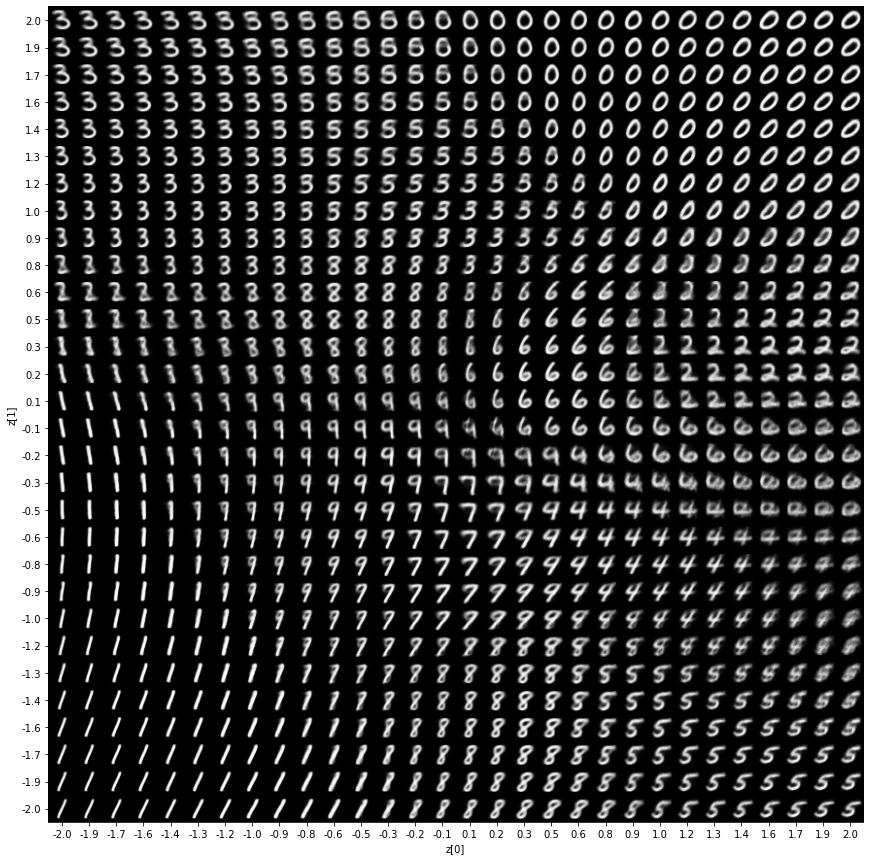

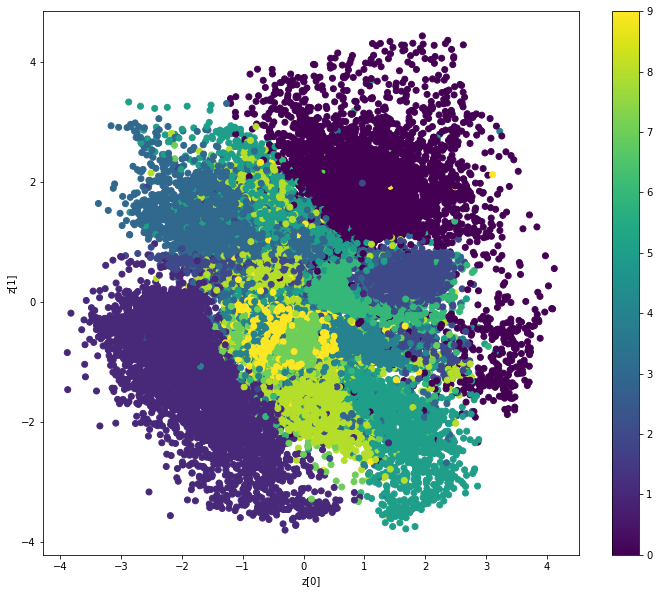

In [45]:
# Model 2
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(128, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(256, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Increasing the number of layers in the model provides an improvement and the model is able to separate better the digits. Decreasing the number of layers don't help the model, because it has a less capacity to detect better the most important features of the digits. We can see by the plot that the most of the dots are overlapped among them.

**Increasing the number of units**

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_167 (Dense)               (None, 512)          401920      input_38[0][0]                   
__________________________________________________________________________________________________
dense_168 (Dense)               (None, 128)          65664       dense_167[0][0]                  
__________________________________________________________________________________________________
dense_169 (Dense)               (None, 64)           8256        dense_168[0][0]                  
____________________________________________________________________________________________

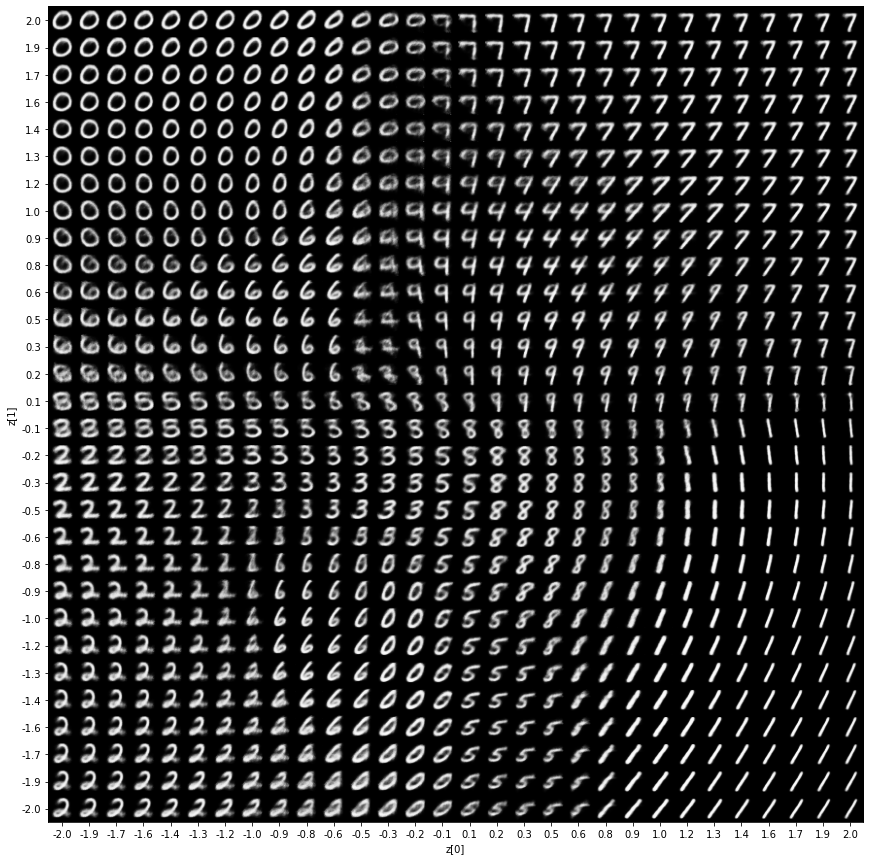

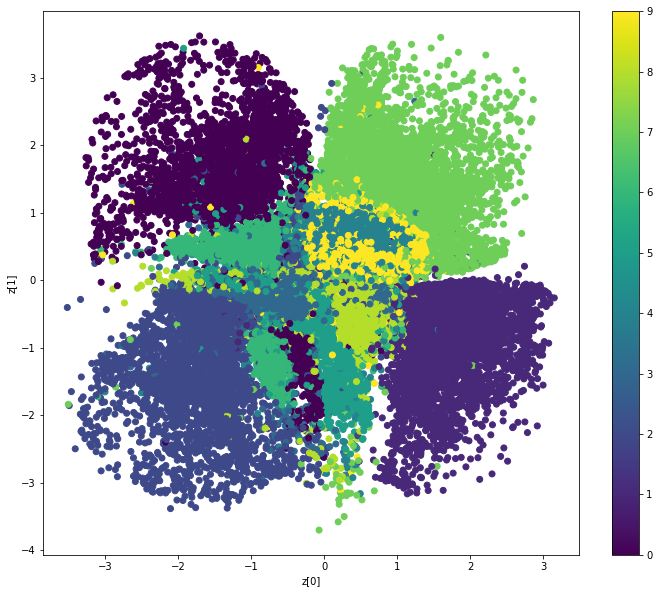

In [46]:
# Model 3
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(512, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(512, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

**Decreasing the number of units**

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_176 (Dense)               (None, 256)          200960      input_40[0][0]                   
__________________________________________________________________________________________________
dense_177 (Dense)               (None, 128)          32896       dense_176[0][0]                  
__________________________________________________________________________________________________
dense_178 (Dense)               (None, 32)           4128        dense_177[0][0]                  
____________________________________________________________________________________________

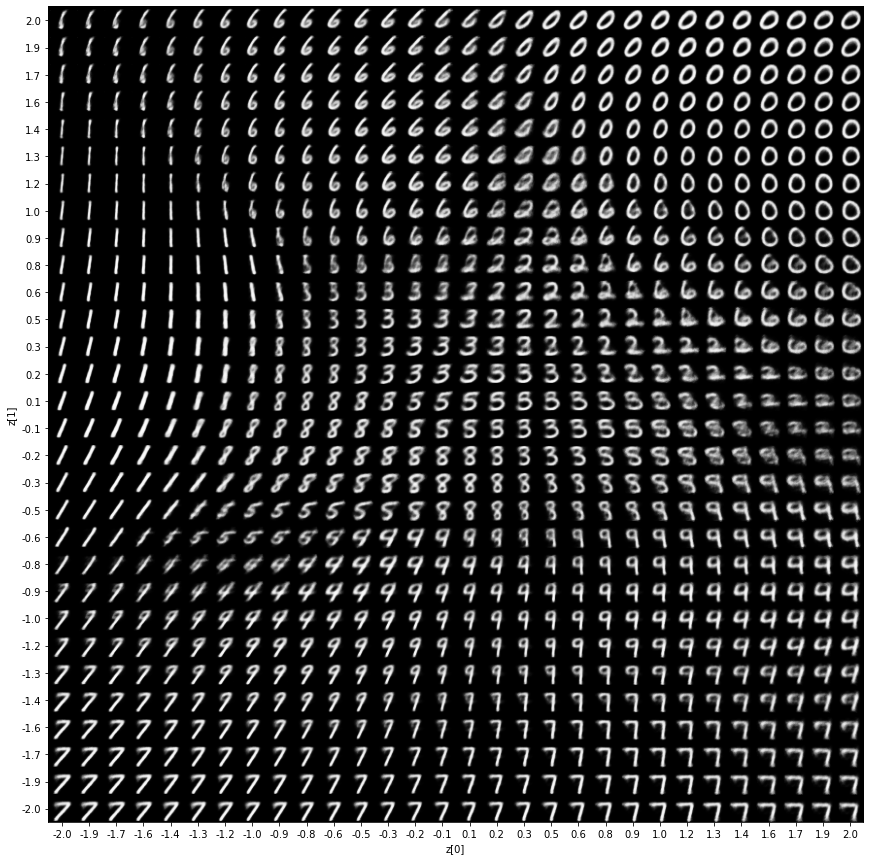

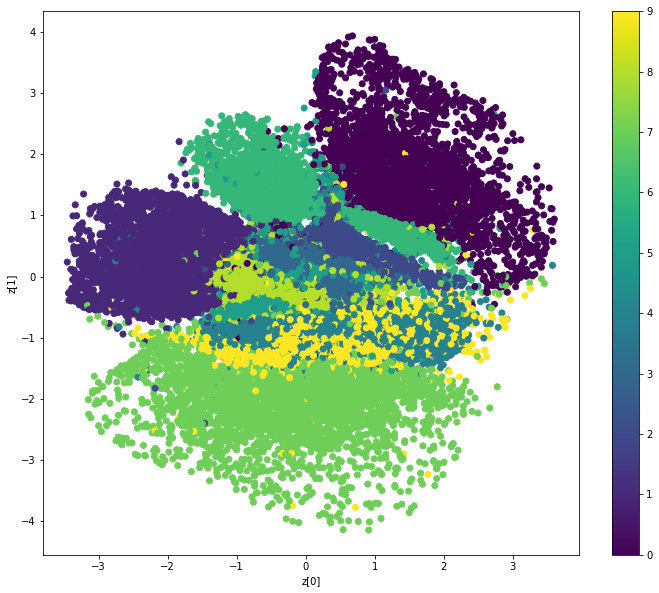

In [47]:
# Model 4
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='tanh')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(32, activation='tanh')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(32, activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.Dense(256, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

I can say the same said before for these two models as well. Increasing the number of units allows the model to have more ability to separate and digits. Instead, decreasing the number of units, reduce the capacity of the model and, as we can see from the plots, the model produces a blurried version of the original digits or it produces a malformed version
 of the original ones.

**ReLU activation function**

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_185 (Dense)               (None, 256)          200960      input_42[0][0]                   
__________________________________________________________________________________________________
dense_186 (Dense)               (None, 128)          32896       dense_185[0][0]                  
__________________________________________________________________________________________________
dense_187 (Dense)               (None, 64)           8256        dense_186[0][0]                  
____________________________________________________________________________________________

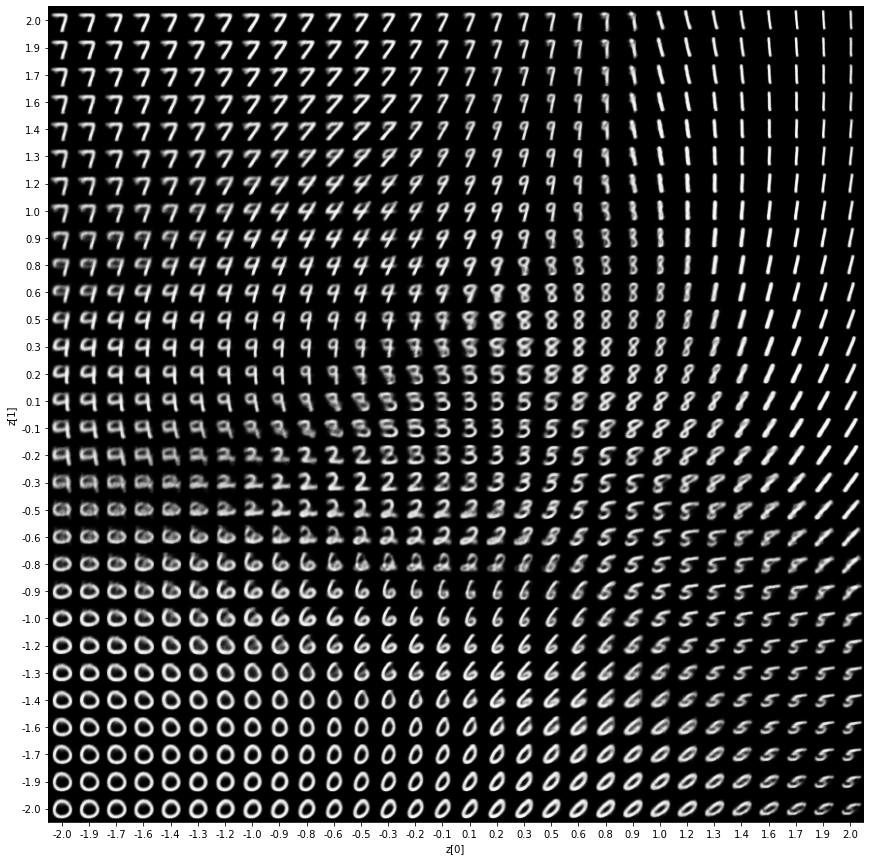

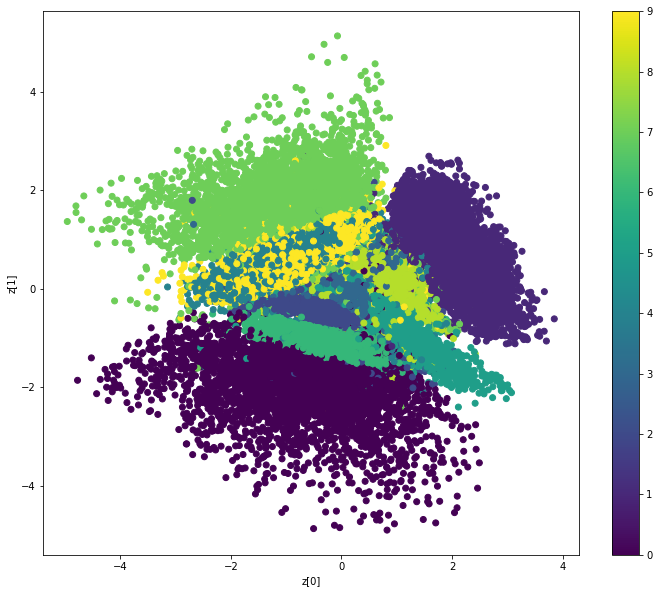

In [48]:
# Model 5
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

**Sigmoid activation function**

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_131 (Dense)               (None, 256)          200960      input_30[0][0]                   
__________________________________________________________________________________________________
dense_132 (Dense)               (None, 128)          32896       dense_131[0][0]                  
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 64)           8256        dense_132[0][0]                  
____________________________________________________________________________________________

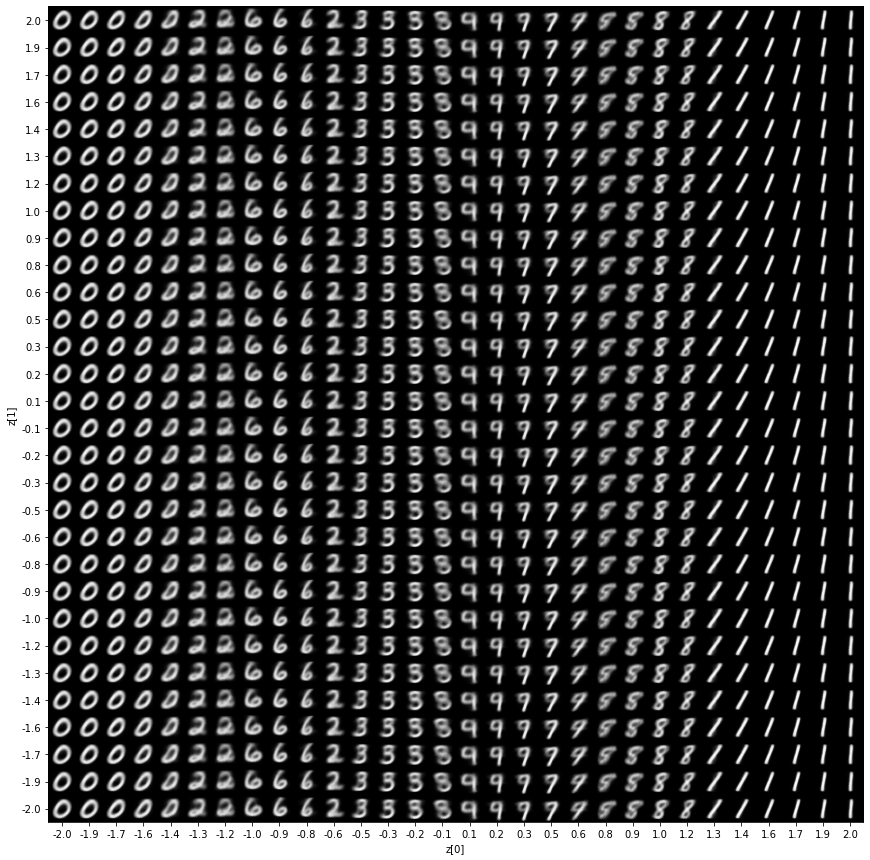

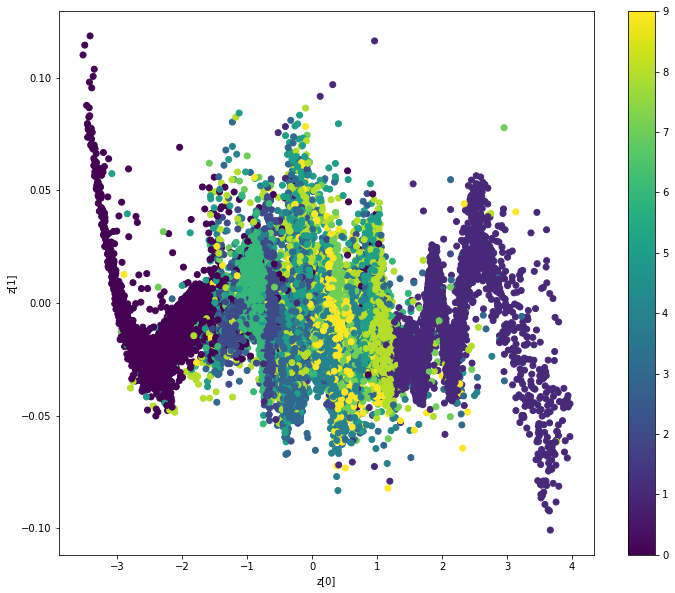

In [33]:
# Model 6
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(256, activation='sigmoid')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='sigmoid')(x)
x = tf.keras.layers.Dense(64, activation='sigmoid')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
z = Sampling()([z_mean, z_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='sigmoid')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='sigmoid')(x)
x = tf.keras.layers.Dense(256, activation='sigmoid')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

plot_latent(encoder, decoder, 2.0, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Using the ReLU activation function seems to produce a similar result to the original one. The reasons could be:
* It's a function that cope at the vanishing problem, because the gradient is always a constant: the derivative of $f(x) = 0$ is 0 while the derivative of $f(x) = x$ is 1;
* It needs less computational resources than sigmoid and tanh. The function needs to be executed to arrive at ReLU is a *max function*: $max(0, x)$ produces 0 when $x < 0$ and $x$ when $x \ge 0$. Computing the output of a max function is simpler and less computationally expensive than computing the output of exponents (such as tanh and sigmoid). For one calculation, this does not matter much, but in deep learning many such calculations are made.

The model with the sigmoid as an activation function produces slightly worse results than the original model. The reason could be by the architecture of the model: the depth of the model could manifest the disappearance problem, a problem this function suffers from. Reducing the number of layers could reduce this problem.